# Installing needed libraries and importing the modules needed

In [ ]:
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 

     |████████████████████████████████| 35.5MB 126kB/s 


In [ ]:
import pandas as pd
import os
import glob
import pydicom
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import logging

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preprocessing

Unzipping the rsna-pneumonia-detection-challenge.zip downloaded from Kaggle into a project folders in Google Drive ( as we are using Google Colab)  

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
#Set your project path 
project_path = "/content/drive/My Drive/aiml_course/pneumonia_detection/"
print(project_path)

/content/drive/My Drive/aiml_course/pneumonia_detection/


In [ ]:

!unzip -q -o "/content/drive/My Drive/aiml_course/pneumonia_detection/"rsna-pneumonia-detection-challenge.zip -d "/content/drive/My Drive/aiml_course/pneumonia_detection/"rsna-pneumonia-detection-challenge

In [ ]:
#!ls
#! mv rsna-pneumonia-detection-challenge  "/content/drive/My Drive/aiml_course/pneumonia_detection/"
! cd "/content/drive/My Drive/aiml_course/pneumonia_detection/"
!ls

drive  sample_data


In [ ]:
project_path = "/content/drive/My Drive/aiml_course/pneumonia_detection/rsna-pneumonia-detection-challenge/rsna-pneumonia-detection-challenge/"

# Analysis of the training data labels 

In [ ]:
df = pd.read_csv(project_path+'stage_2_train_labels.csv')

In [ ]:
df.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [ ]:
df.describe()

x            y        width       height        Target
count  9555.000000  9555.000000  9555.000000  9555.000000  30227.000000
mean    394.047724   366.839560   218.471376   329.269702      0.316108
std     204.574172   148.940488    59.289475   157.750755      0.464963
min       2.000000     2.000000    40.000000    45.000000      0.000000
25%     207.000000   249.000000   177.000000   203.000000      0.000000
50%     324.000000   365.000000   217.000000   298.000000      0.000000
75%     594.000000   478.500000   259.000000   438.000000      1.000000
max     835.000000   881.000000   528.000000   942.000000      1.000000

In [ ]:
df.shape

(30227, 6)

In [ ]:
df['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [ ]:
df['TargetCategorical'] = df.Target.astype('category')

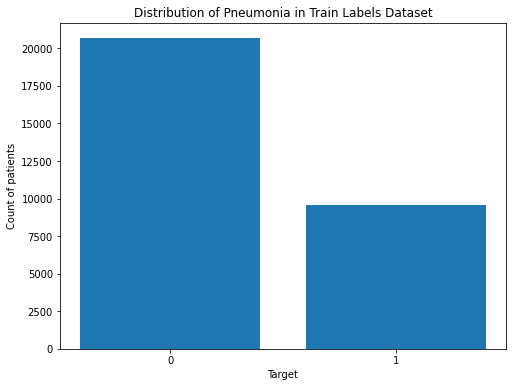

In [ ]:
plt.figure(figsize=(8,6))
x = range(2)
plt.bar(x, df['TargetCategorical'].value_counts())
plt.xticks(df.TargetCategorical.value_counts().index.categories)
plt.xlabel('Target')
plt.ylabel('Count of patients')
plt.title('Distribution of Pneumonia in Train Labels Dataset')
plt.show()

The ratio of Pneumonia to non-Pneumonia in the training data set is approximately 1:2. 

In [ ]:
duplicates = df[df.duplicated()]
duplicates

Empty DataFrame
Columns: [patientId, x, y, width, height, Target, TargetCategorical]
Index: []

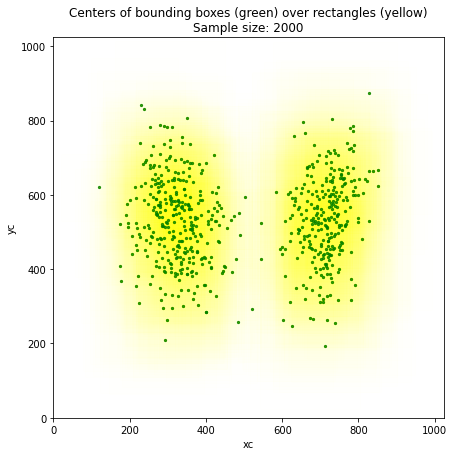

In [ ]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1,1,figsize=(7,7))
df_sample = df.sample(2000)
df_sample['xc'] = df_sample['x'] + df_sample['width'] / 2
df_sample['yc'] = df_sample['y'] + df_sample['height'] / 2
plt.title("Centers of bounding boxes (green) over rectangles (yellow)\nSample size: 2000")
df_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="green")
for i, crt_sample in df_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

Scatter plot of the distribution of opacity bounding boxes in a sample (n=2000) of the data. 

# Analysis of the Detailed Class Info 
Loading these into a separate dataframe and analysing

In [ ]:
df2 = pd.read_csv(project_path+'stage_2_detailed_class_info.csv')

In [ ]:
print(df2.shape)
df2.head()

(30227, 2)


patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [ ]:
duplicates = df2[df2.duplicated()]
duplicates.shape

(3543, 2)

***There are 3543 duplicate rows in the Detailed Calss Info data set***

In [ ]:
df2 = df2.drop_duplicates()

In [ ]:
print(df2.shape)
df2.head()

(26684, 2)


patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [ ]:
df2['class'].value_counts()

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

In [ ]:
df2["classCategorical"] = df2['class'].astype('category')

In [ ]:
df2.classCategorical.value_counts().index.categories

Index(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'], dtype='object')

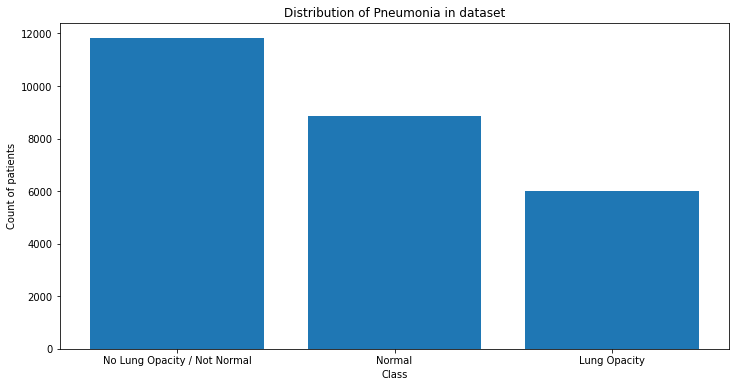

In [ ]:
plt.figure(figsize=(12,6))
x = range(3)
plt.bar(x, df2['classCategorical'].value_counts())
plt.xticks(x, df2.classCategorical.value_counts().index)
plt.xlabel('Class')
plt.ylabel('Count of patients')
plt.title('Distribution of Pneumonia in dataset')
plt.show()

# Loading images and extracting meta data from the DICOM header

In [ ]:
def get_dicom_files_list(folder_path) :
  print(folder_path)
  files = glob.glob(folder_path+"/"+"*.dcm")
  return (list(set(files))) 

In [ ]:
train_dicom_files = get_dicom_files_list(project_path+"stage_2_train_images")
test_dicom_files = get_dicom_files_list(project_path+"stage_2_test_images")

print ("Count of DICOM files in training folder :" , len(train_dicom_files))
print ("Count of DICOM files in test folder :", len(test_dicom_files) )
#ds = pydicom.read_file() # read dicom image from filepath 
#image = ds.pixel_array # get image array

/content/drive/My Drive/aiml_course/pneumonia_detection/rsna-pneumonia-detection-challenge/rsna-pneumonia-detection-challenge/stage_2_train_images
/content/drive/My Drive/aiml_course/pneumonia_detection/rsna-pneumonia-detection-challenge/rsna-pneumonia-detection-challenge/stage_2_test_images
Count of DICOM files in training folder : 0
Count of DICOM files in test folder : 2071


In [ ]:


DICOM_META_DATA_COLUMNS = ['PatientAge', 'PatientID','PatientSex',]
def extract_dicom_header(dicom_file):
  #dicom0.dir()
  dicom0 = pydicom.read_file(dicom_file, stop_before_pixels=True)
  header_dict = {}
  for i in dicom0.dir() :
    if (i in DICOM_META_DATA_COLUMNS):
      header_dict[i] = dicom0[i].value
  #print (header_dict)
  return header_dict


def get_dicom_headers(files_list):
  dicom_headers = [] #pd.DataFrame(columns=DICOM_META_DATA_COLUMNS)
  iter = 0
  max_iter =40000 
  for dicom_file in files_list :
    headers_dict = extract_dicom_header(dicom_file)    
    iter+=1 
    if (iter%1000 ==0):
      print(iter)
    if iter > max_iter:
      break
    dicom_headers.append(headers_dict)
  df = pd.DataFrame(dicom_headers)
  return df





In [ ]:
from queue import Queue
from threading import Thread

DICOM_META_DATA_COLUMNS = ['PatientAge', 'PatientID','PatientSex',]

def process_dicom_header(q, result):
    while not q.empty():
        work = q.get()
        try:
              dicom0 = pydicom.read_file(work[1], stop_before_pixels=True)
              header_dict = {}
              for i in dicom0.dir() :
                if (i in DICOM_META_DATA_COLUMNS):
                  header_dict[i] = dicom0[i].value
              #print("Processed..." + work[1])
              result[work[0]] = header_dict          #Store data back at correct index
        except:
            print('Error with File read!')
            result[work[0]] = {}
        q.task_done()
    return True    

def get_dicom_file_headers(files_list):
  q = Queue(maxsize=0)
  num_theads = min(5, len(files_list))
  results = [{} for x in files_list];
  for i in range(len(files_list)):
    q.put((i,files_list[i]))
  for i in range(num_theads):
    #print('Starting thread ', i)
    worker = Thread(target=process_dicom_header, args=(q,results))
    worker.setDaemon(True)    #setting threads as "daemon" allows main program to 
                              #exit eventually even if these dont finish 
                              #correctly.
    worker.start()
  #now we wait until the queue has been processed
  q.join()
  return results

In [ ]:
#df3= get_dicom_file_headers(train_dicom_files)
df3= get_dicom_headers(train_dicom_files)
print(df3.shape)
df3.head()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
(26720, 3)


PatientAge                             PatientID PatientSex
0         51  e75be7c1-7a25-4316-a400-0e9126d0d3fb          F
1         64  d8b63ce5-796b-421d-a044-56c1bc01ecf8          F
2         42  c252b18a-102c-463c-96e7-5c48dede71dd          F
3         26  ce0f8abe-6b5e-4fb8-b606-f8656f720896          F
4         35  4ba09dcd-acd3-4ef2-9b27-7cfce5adf04e          F

We created a dataframe that loaded all the PatientID and PatientSex from the training images metadata. 

In [ ]:
duplicateDFRow = df3[df3.duplicated()]
duplicateDFRow.shape

(36, 3)

There are 36 duplicates in the train images. 

In [ ]:
df3_dedup = df3.drop_duplicates()

In [ ]:
df4= get_dicom_headers(test_dicom_files)

1000
2000
3000


In [ ]:
print(df4.shape)
df4.head()

(3000, 3)


PatientAge                             PatientID PatientSex
0         31  2a1276a9-c806-480d-80ac-008d1bcb469f          F
1         55  23c0da4c-d481-45d5-8cf8-ac77f20e424c          M
2         50  03e146ff-fd62-4188-9ffa-c61b8f89ac8d          M
3         32  041a2204-51fb-4d23-8204-dd6a7a6f5ee3          F
4         60  2017c617-7593-4996-9faf-3db972b7e7d9          M

We created a dataframe that loaded all the PatientID and PatientSex from the test images metadata. 

In [ ]:
duplicateDFRow = df4[df4.duplicated()]
duplicateDFRow.shape

(0, 3)

# Merging the datasets to analyse the target, class and image headers

In [ ]:
pn_df = pd.merge(left=df, right=df2, left_on='patientId', right_on='patientId', how='inner')

In [ ]:
print(pn_df.shape)
pn_df.head()

(30227, 9)


patientId  ...              classCategorical
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  ...  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4  ...                  Lung Opacity

[5 rows x 9 columns]

In [ ]:
print(pd.isna(pn_df['Target']).sum())
print(pd.isna(pn_df['class']).sum())

duplicateDFRow = pn_df[pn_df.duplicated()]
duplicateDFRow

0
0


Empty DataFrame
Columns: [patientId, x, y, width, height, Target, TargetCategorical, class, classCategorical]
Index: []

In [ ]:
pn_df['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [ ]:
pn_df['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [ ]:
files_df = df3_dedup.append(df4)

In [ ]:
print(files_df.shape)
files_df.head()

(29684, 3)


PatientAge                             PatientID PatientSex
0         51  e75be7c1-7a25-4316-a400-0e9126d0d3fb          F
1         64  d8b63ce5-796b-421d-a044-56c1bc01ecf8          F
2         42  c252b18a-102c-463c-96e7-5c48dede71dd          F
3         26  ce0f8abe-6b5e-4fb8-b606-f8656f720896          F
4         35  4ba09dcd-acd3-4ef2-9b27-7cfce5adf04e          F

In [ ]:
pn_df = pd.merge(left=pn_df, right=files_df, left_on='patientId', right_on='PatientID')


In [ ]:
print(pn_df.shape)
pn_df.head()

(30227, 12)


patientId  ...  PatientSex
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...           F
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...           F
2  00322d4d-1c29-4943-afc9-b6754be640eb  ...           M
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...           M
4  00436515-870c-4b36-a041-de91049b9ab4  ...           F

[5 rows x 12 columns]

In [ ]:
pn_df['PatientAge'] = pn_df['PatientAge'].astype(str).astype(int)

In [ ]:
plt.figure(figsize=(24,12))
plt.hist(pn_df["PatientAge"].sort_values(ascending=True), bins =25)
plt.show()

The age distribution looks like a slightly right skewed normal distribution. 

There are a few outliers noted, possible due to wrong entry and their age is around 150 years old.  

In [ ]:
pn_df[pn_df['PatientAge'] >= 120]

patientId  ...  PatientSex
3921   3b8b8777-a1f6-4384-872a-28b95f59bf0d  ...           M
11032  73aeea88-fc48-4030-8564-0a9d7fdecac4  ...           F
17213  a4e8e96d-93a6-4251-b617-91382e610fab  ...           M
26488  ec3697bd-184e-44ba-9688-ff8d5fbf9bbc  ...           M
27746  f632328d-5819-4b29-b54f-adf4934bbee6  ...           F

[5 rows x 12 columns]

In [ ]:
pn_df['PatientSex'].value_counts()

M    17216
F    13011
Name: PatientSex, dtype: int64

There are about 30% more males than females in the training dataset. 

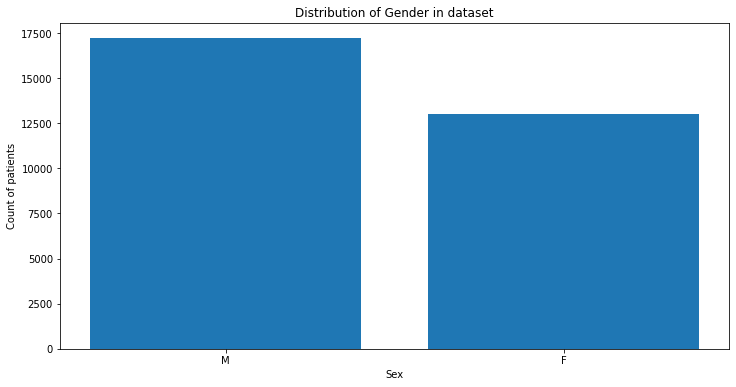

In [ ]:
plt.figure(figsize=(12,6))
x = range(2)
plt.bar(x, pn_df['PatientSex'].value_counts())
plt.xticks(x, pn_df.PatientSex.value_counts().index)
plt.xlabel('Sex')
plt.ylabel('Count of patients')
plt.title('Distribution of Gender in dataset')
plt.show()

In [ ]:
my_tab= pd.crosstab(pn_df['PatientSex'],pn_df['Target'])
my_tab

Target          0     1
PatientSex             
F            9016  3995
M           11656  5560

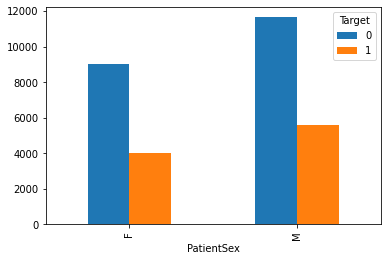

In [ ]:
my_tab.plot.bar()

The proportion of pnemonia cases in both genders appears similar. 

In [ ]:
my_tab= pd.crosstab(pn_df['classCategorical'],pn_df['PatientSex'])
my_tab

PatientSex                       F     M
classCategorical                        
Lung Opacity                  3995  5560
No Lung Opacity / Not Normal  5111  6710
Normal                        3905  4946

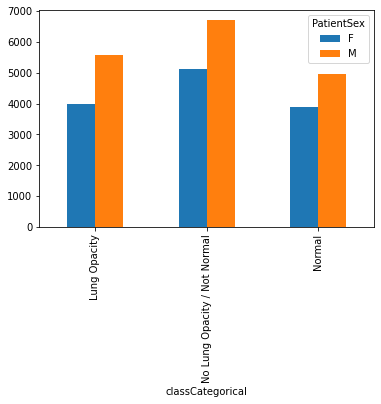

In [ ]:
my_tab.plot.bar()

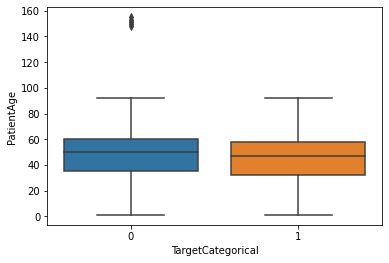

In [ ]:
sns.boxplot(x='TargetCategorical', y = 'PatientAge', data=pn_df)

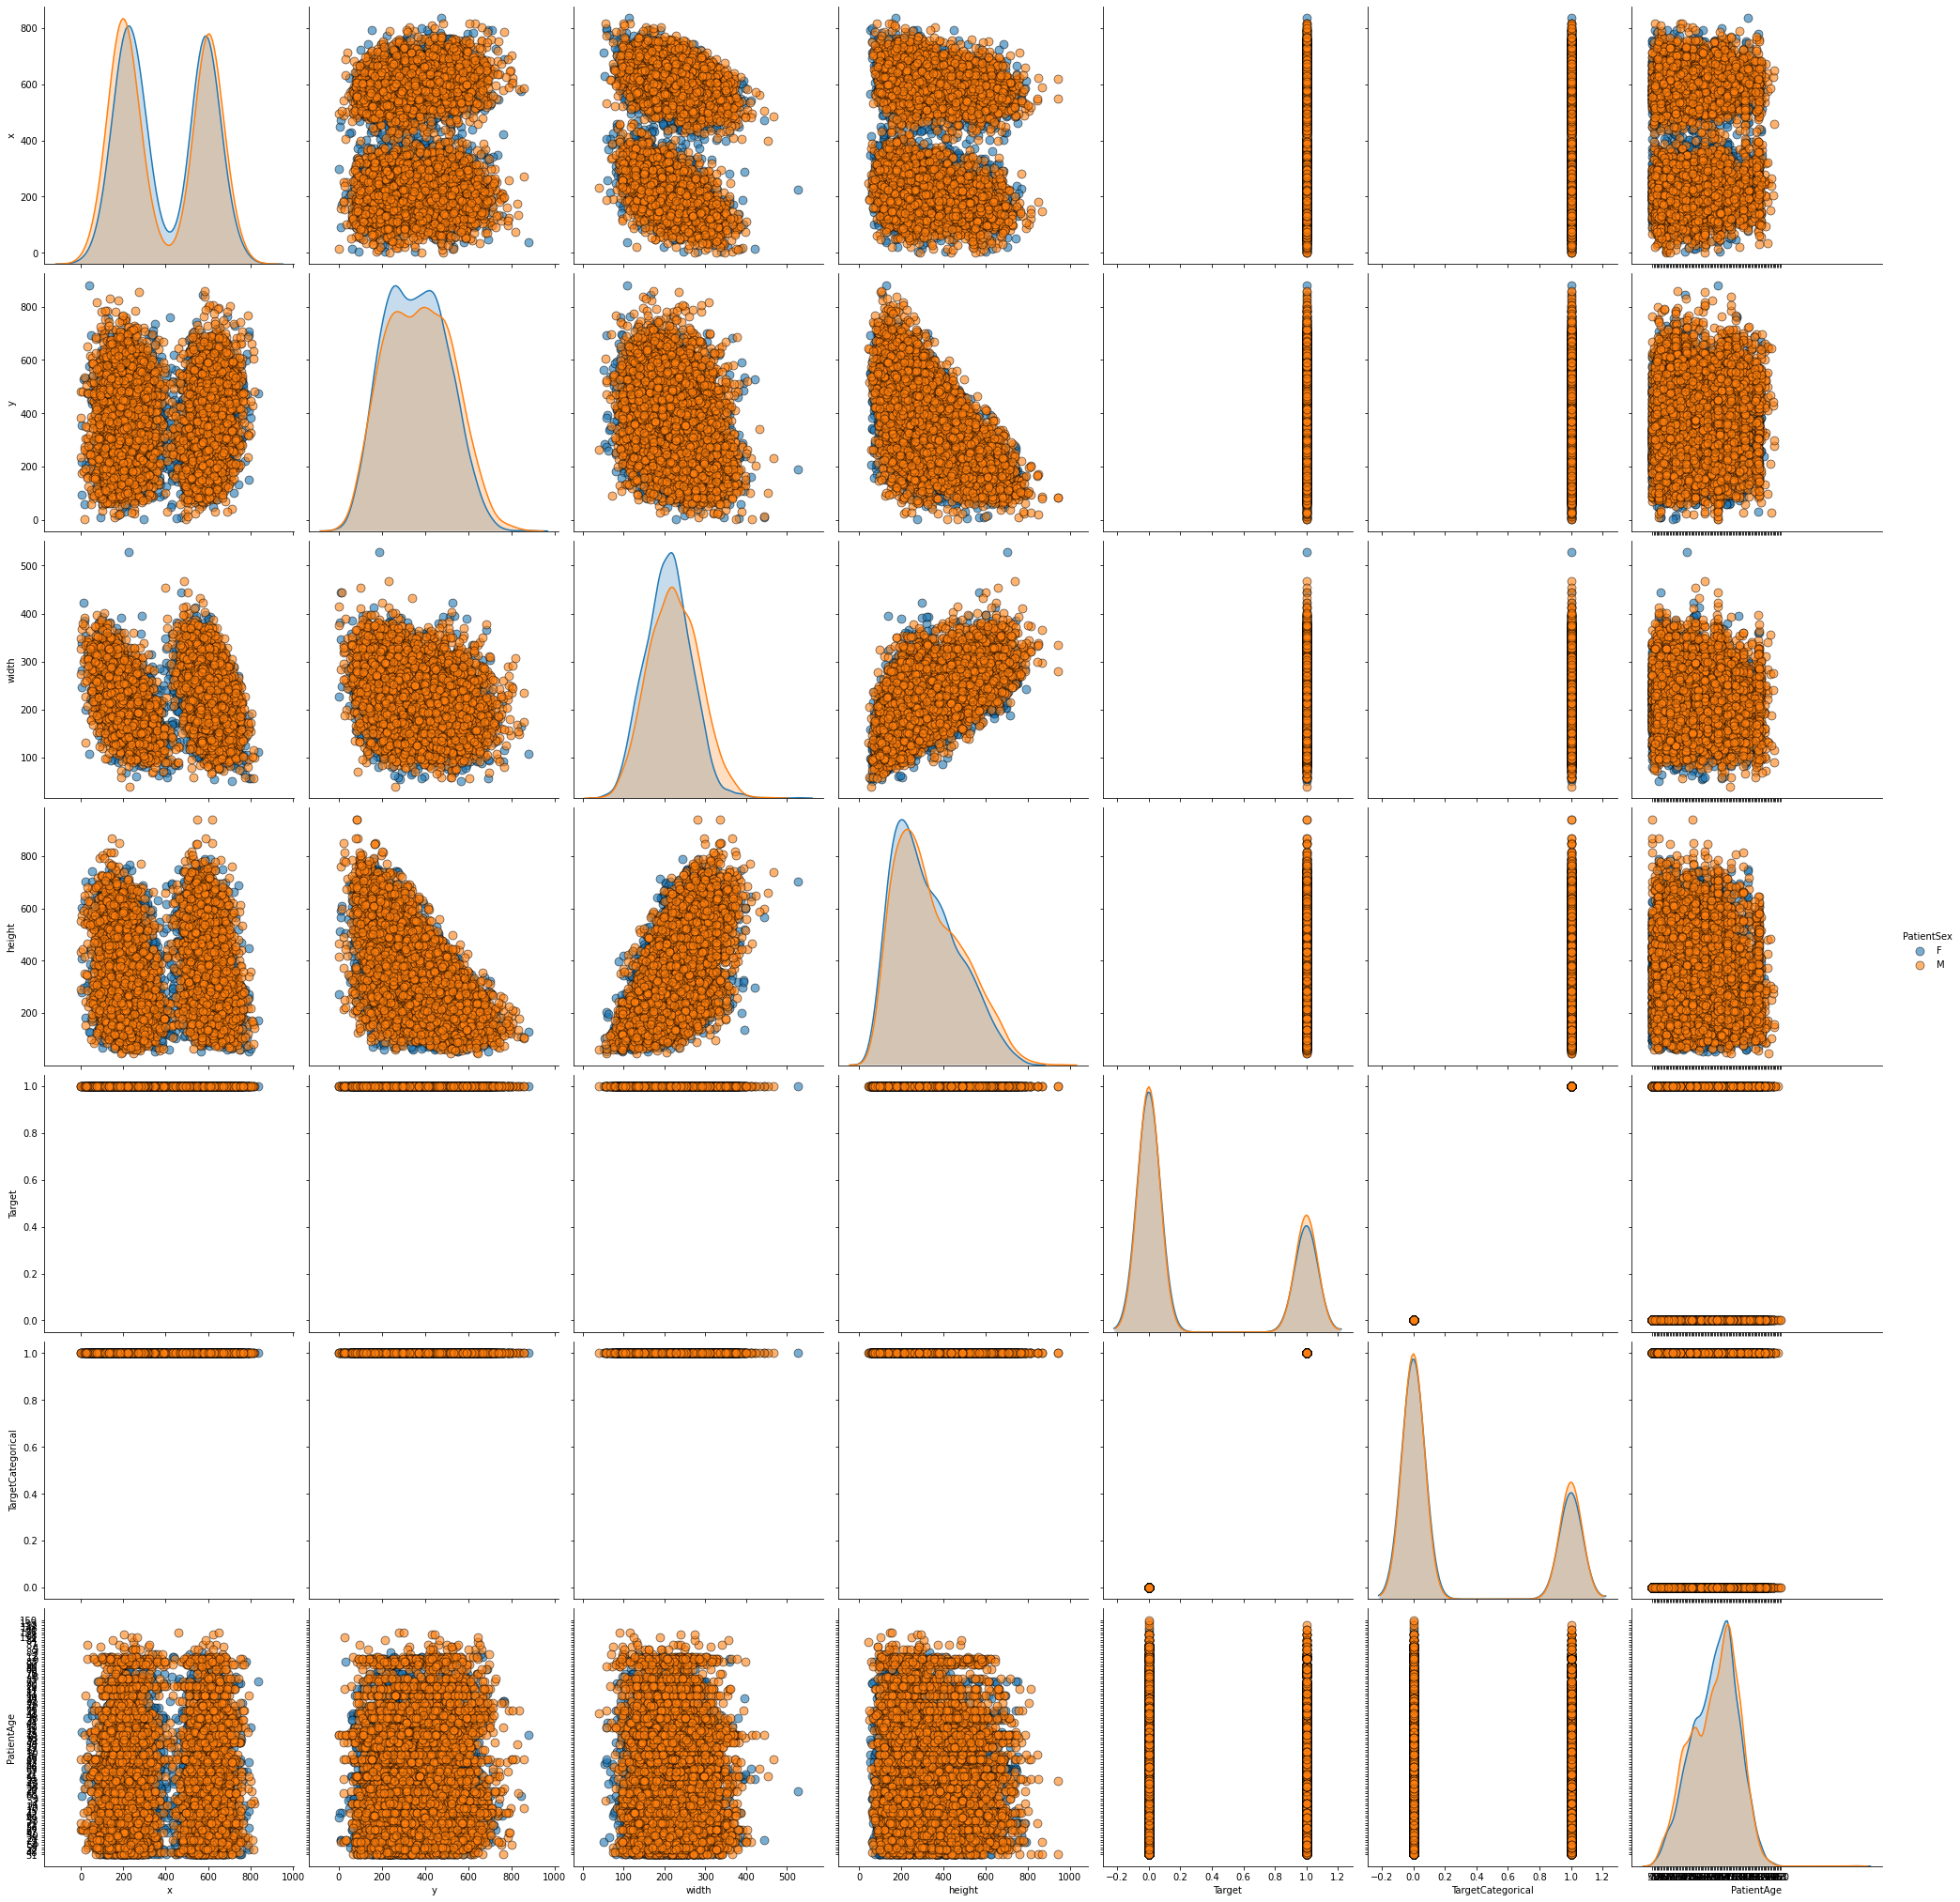

In [ ]:
sns.pairplot(pn_df, hue="PatientSex", diag_kind = 'kde', plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4)

We can note that X has 2 peaks attributed to the opacity bounding boxes being present in 2 lungs only. 


Visualization of an image 

In [ ]:
def get_image(dicom_file):
  f = pydicom.read_file(dicom_file)
  image = f.pixel_array # get image array
  if len(image.shape) != 3 or image.shape[2] != 3:
    image = np.stack((image,) * 3, -1)
  #print (image)
  #plt.imshow(image, cmap='gray')
  return image


plt.imshow(get_image(train_dicom_files[0]), cmap='gray')